# NLP no-Transformer: Training

In [1]:
!pip install Wikidata
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [2]:
import torch, random, requests, os, pickle
import numpy as np
from wikidata.client import Client
from datasets import load_dataset
from itertools import islice
from google.colab import userdata
from google.colab import drive

Setting seeds to try to make the training as much deterministic as possible.
This should help to compare results (for the instance accuracy of the validation test) of different trainings.

In [3]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Wikipedia pages and Wikidata data need to be loaded from the web.
In order to speed up the training and the inference, we store (cache) the retrieved and the processed data in files.

In [4]:
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/Lost_in_Language_Recognition/'

def dump(file_name, result):
    file_path = BASE_PATH + file_name
    # remove dump files if present
    if os.path.exists(file_path):
        os.remove(file_path)
    with open(file_path, 'wb') as file:
        print("dumping", file_path)
        # noinspection PyTypeChecker
        pickle.dump(result, file)

def load(file_name):
    file_path = BASE_PATH + file_name
    with open(file_path, 'rb') as file:
        print("loading", file_path)
        # noinspection PyTypeChecker
        return pickle.load(file)

def file_exists(file_name):
    file_path = BASE_PATH + file_name
    return os.path.exists(file_path)

Mounted at /content/drive


In this section we build the singleton `NLPDataset`, that contains:
1. The original Hugging Face dataset
2. The Wikidata entities
3. The Wikipedia pages

In [5]:
def wikipedia_pages(sitelinks):
    result = []
    for site_key in sitelinks.keys():
        if site_key.endswith("wiki") and not site_key.startswith("commons"):
            lang = site_key.replace("wiki", "")
            result.append(lang)
    return result

def build_claims(claims):
    result = {}
    for prop_id, values in claims.items():
        result[prop_id] = len(values)
    return result

class Entity:
    def __init__(self, entity_id, dataset_item, wiki_data, wiki_text):
        self.entity_id = entity_id
        self.label = dataset_item['label']
        self.name = dataset_item['name']
        self.description = dataset_item['description']
        self.type = dataset_item['type']
        self.category = dataset_item['category']
        self.subcategory = dataset_item['subcategory']
        self.wiki_text = wiki_text
        # Languages
        self.labels = list(wiki_data.data.get("labels", {}).keys())
        self.descriptions = list(wiki_data.data.get("descriptions", {}).keys())
        self.aliases = list(wiki_data.data.get("aliases", {}).keys())
        self.wikipedia_pages = wikipedia_pages(wiki_data.data.get("sitelinks", {}))
        # Properties
        self.claims = build_claims(wiki_data.data.get("claims", {}))

    def __str__(self):
        return self.entity_id + ": " + self.label + " - " + self.name

API_URL = "https://en.wikipedia.org/w/api.php"

def extract_entity_id(url):
    return url.strip().split("/")[-1]

def get_wiki_text(en_wiki):
    if not en_wiki:
        return None
    title = en_wiki["title"]
    params = {
        "action": "query",
        "prop": "extracts",
        "explaintext": True,
        "titles": title,
        "format": "json",
        "redirects": 1
    }
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36'}
    res = requests.get(API_URL, params=params, headers=headers)
    json = res.json()
    page = next(iter(json["query"]["pages"].values()))
    # Keep the original text as it is.
    # The text will be processed in other methods,
    # such as processed_dataset#tokenize().
    return page.get("extract", "")

class EntityFactory:
    def __init__(self, client):
        self.client = client

    def create(self, item):
        entity_id = extract_entity_id(item['item'])
        try:
            wikidata = self.client.get(entity_id, load=True)
            sitelinks = wikidata.data.get("sitelinks", {})
            en_wiki = sitelinks.get("enwiki")
            return Entity(entity_id, item, wikidata, get_wiki_text(en_wiki))
        except Exception as e:
            print("Error loading id:", entity_id, e)
            return None

TRAINING_FILE_NAME = "training.bin"
VALIDATION_FILE_NAME = "validation.bin"

def create_set(dataset, factory, limit, file_name):
    # apply the limits
    if limit is None:
        limit = len(dataset)
    result = []
    for index, item in enumerate(islice(dataset, limit)):
        created = factory.create(item)
        if created is not None:
            result.append(created)
        if (index + 1) % 10 == 0:
            print("creating", file_name, index + 1, "/", limit)
    return result

class NLPDataset:
    def __init__(self, training_limit=None, validation_limit=None, force_reload=False):
        if not (file_exists(TRAINING_FILE_NAME)) or not (file_exists(VALIDATION_FILE_NAME)) or force_reload:
            # load the project dataset
            dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset', token=userdata.get('HF_TOKEN'))
            # a factory object is used to create our entities
            factory = EntityFactory(Client())

            self.training_set = create_set(dataset['train'], factory, training_limit, TRAINING_FILE_NAME)
            self.validation_set = create_set(dataset['validation'], factory, validation_limit, VALIDATION_FILE_NAME)
            dump(TRAINING_FILE_NAME, self.training_set)
            dump(VALIDATION_FILE_NAME, self.validation_set)
        else:
            # by default load the dataset from a local dump
            self.training_set = load(TRAINING_FILE_NAME)
            self.validation_set = load(VALIDATION_FILE_NAME)

    def __str__(self):
        return "training: " + str(len(self.training_set)) + ". validation: " + str(len(self.validation_set))

In [6]:
nlp_dataset = NLPDataset()

loading /content/drive/MyDrive/Lost_in_Language_Recognition/training.bin
loading /content/drive/MyDrive/Lost_in_Language_Recognition/validation.bin


If the dump files `training.bin` and `validation.bin` are present, the instance is build from the dump.
Without transformers we're going to process manually fields and texts.
In the following code:
1. dictionaries are created to produce frequency vectors
2. GloVe pretrained embeddings are applied to the descriptions
3. the labels are mapped to numbers
4. Category and subcategories are mapped to a single scalar value for each entity - pandas is used to group the ids of the subcategories by the category

The result is a singleton `ProcessedDataset` that extends the base `NLPDataset`
providing also the `ProcessedEntity`s of the corresponding (base) `Entity`.

Finally the result of the processing is dumped and can be reused to the next run


In [7]:
!pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [8]:
import collections, nltk, string
import pandas as pd
from torchtext.vocab import GloVe
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import IterableDataset

In [9]:
def type_vector(base_type):
    vector = np.zeros(1, dtype=np.float32)
    if base_type == 'entity':
        vector[0] = vector[0] + 1
    return vector

def label_to_number(label):
    if label == 'cultural agnostic':
        return 0
    if label == 'cultural representative':
        return 1
    if label == 'cultural exclusive':
        return 2
    raise ValueError('label not suppoerted: ' + label)

class ProcessedEntity:
    def __init__(self, base: Entity, desc_text, wiki_text):
        self.base_entity = base.entity_id + ": " + base.name
        # processed fields
        self.desc_text = desc_text
        self.wiki_text = wiki_text
        self.labels_text = base.labels
        self.descriptions_text = base.descriptions
        self.aliases_text = base.aliases
        self.pages_text = base.wikipedia_pages
        # Using map to denote a Python dictionary,
        # since the dictionary is already use for a word (term) dictionary
        self.claims_map = base.claims
        self.subcategory = base.subcategory
        self.category = base.category

        # build later (then the dictionaries are finalized)
        self.desc_vector = None
        self.wiki_vector = None
        self.labels_vector = None
        self.descriptions_vector = None
        self.aliases_vector = None
        self.pages_vector = None
        self.claims_vector = None
        # it includes implicitly the category
        # since the subcategory values have been ordered by category
        self.subcategory_vector = None
        # in this case we can assume that we have only two types (entity vs concept)
        self.type_vector = type_vector(base.type)
        self.desc_glove_vector = None
        self.output_label = label_to_number(base.label)

    def __str__(self):
        return self.base_entity + " < " + str(len(self.desc_text)) + ", " + str(len(self.wiki_text)) + " >"

    def dataset_item(self):
        return {
            "desc" : self.desc_vector,
            "wiki" : self.wiki_vector,
            "labels" : self.labels_vector,
            "descriptions" : self.descriptions_vector,
            "aliases" : self.aliases_vector,
            "pages" : self.pages_vector,
            "claims" : self.claims_vector,
            "category" : self.subcategory_vector,
            "type" : self.type_vector,
            "desc_glove" : self.desc_glove_vector,
            "output_label" : self.output_label,
            "base" : self.base_entity
        }

class CategoryTable:
    def __init__(self):
        self.subcategories_entered = {}  # to avoid duplicates
        self.subcategories = []
        self.categories = []
        self.subcategory_to_id = None  # computed on build

    def include(self, processed_entity: ProcessedEntity):
        if processed_entity.subcategory in self.subcategories_entered:
            return
        self.subcategories_entered[processed_entity.subcategory] = True
        self.subcategories.append(processed_entity.subcategory)
        self.categories.append(processed_entity.category)

    def build(self):
        data = {
            'subcategory': self.subcategories,
            'category': self.categories
        }
        df = pd.DataFrame(data)
        df = df.sort_values('category')
        print(df.to_markdown())
        self.subcategory_to_id = {row["subcategory"]: index for index, (_, row) in enumerate(df.iterrows())}

    def subcat_to_vector(self, subcategory):
        vector = np.zeros(1, dtype=np.float32)
        vector[0] = vector[0] + self.subcategory_to_id[subcategory]
        return vector

    def length(self):
        return len(self.subcategory_to_id)

class Dictionary:
    def __init__(self):
        self.occurrences = []
        self.unk_token = None
        self.word_to_id = None

    def include(self, tokenized_text):
        self.occurrences.extend(tokenized_text)

    def build(self, max_vocab_size, unk_token):
        self.unk_token = unk_token
        counter = collections.Counter(self.occurrences)
        self.word_to_id = {key: index for index, (key, _) in enumerate(counter.most_common(max_vocab_size - 1))}
        assert unk_token not in self.word_to_id
        self.word_to_id[unk_token] = max_vocab_size - 1
        self.occurrences = None # free memory space

    def build_no_limits(self):
        counter = collections.Counter(self.occurrences)
        self.word_to_id = {key: index for index, (key, _) in enumerate(counter.most_common())}
        self.occurrences = None # free memory space

    def length(self):
        return len(self.word_to_id)

    def words_to_vector(self, words):
        vector = np.zeros(self.length(), dtype=np.float32)
        for word in words:
            if word == self.unk_token:
                continue
            if word in self.word_to_id:
                vector[self.word_to_id[word]] = vector[self.word_to_id[word]] + 1
        return vector

    # Using map to denote a Python dictionary,
    # since the dictionary is already use for a word (term) dictionary
    def map_to_vector(self, dictionary):
        vector = np.zeros(self.length(), dtype=np.float32)
        for word, freq in dictionary.items():
            if word == self.unk_token:
                continue
            if word in self.word_to_id:
                vector[self.word_to_id[word]] = freq
        return vector

PAD_TOKEN = '<PAD>'

class GloveProcessing:
    def __init__(self, context_size):
        self.glove = GloVe(name='6B', dim=100)
        self.context_size = context_size

    def words_to_vect(self, words):
        return self.glove.get_vecs_by_tokens(self.tokens(words)).view(-1)

    def tokens(self, words):
        return words[:self.context_size] + [PAD_TOKEN]*(self.context_size-len(words))

UNK = '<UNK>' # the token to be used for out of vocabulary words
DESC_VOCAB_SIZE = 4_000
WIKI_VOCAB_SIZE = 10_000
GLOVE_EMBEDDING_SIZE = 20

class Dictionaries:
    def __init__(self):
        # descriptions and wiki text words are in 2 different vector spaces
        self.desc = Dictionary()
        self.wiki = Dictionary()
        # we use the same languages keys dictionaries for:
        # labels_text, descriptions_text, aliases_text, pages_text
        self.languages = Dictionary()
        self.claims = Dictionary()
        self.category_table = CategoryTable()
        # extra add glove embeddings
        self.glove_desc = GloveProcessing(GLOVE_EMBEDDING_SIZE)

    def include(self, processed_entity: ProcessedEntity):
        self.desc.include(processed_entity.desc_text)
        self.wiki.include(processed_entity.wiki_text)
        self.languages.include(processed_entity.labels_text)
        self.languages.include(processed_entity.descriptions_text)
        self.languages.include(processed_entity.aliases_text)
        self.languages.include(processed_entity.pages_text)
        self.claims.include(list(processed_entity.claims_map.keys()))
        self.category_table.include(processed_entity)

    def build(self):
        self.desc.build(DESC_VOCAB_SIZE, UNK)
        self.wiki.build(WIKI_VOCAB_SIZE, UNK)
        self.claims.build_no_limits()
        # those guys are not too large: so we can not limit them
        self.languages.build_no_limits()
        self.category_table.build()

    def finalize(self, processed_entity: ProcessedEntity):
        processed_entity.desc_vector = self.desc.words_to_vector(processed_entity.desc_text)
        processed_entity.wiki_vector = self.wiki.words_to_vector(processed_entity.wiki_text)
        processed_entity.labels_vector = self.languages.words_to_vector(processed_entity.labels_text)
        processed_entity.descriptions_vector = self.languages.words_to_vector(processed_entity.descriptions_text)
        processed_entity.aliases_vector = self.languages.words_to_vector(processed_entity.aliases_text)
        processed_entity.pages_vector = self.languages.words_to_vector(processed_entity.pages_text)
        processed_entity.claims_vector = self.claims.map_to_vector(processed_entity.claims_map)
        processed_entity.subcategory_vector = self.category_table.subcat_to_vector(processed_entity.subcategory)
        processed_entity.desc_glove_vector = self.glove_desc.words_to_vect(processed_entity.desc_text)

class IterableEntities(IterableDataset):
    def __init__(self, processed_entities: list[ProcessedEntity]):
        self.processed_entities = processed_entities

    def __iter__(self):
        for entity in self.processed_entities:
            yield entity.dataset_item()

    def __len__(self):
        return len(self.processed_entities)

TRAINING_PROC_FILE_NAME = "training-proc.bin"
VALIDATION_PROC_FILE_NAME = "validation-proc.bin"

def text_process(text, stop):
    result = []
    if text is None:
        return result
    for sentence in nltk.sent_tokenize(text.lower()):
        result.extend([WordNetLemmatizer().lemmatize(i) for i in nltk.word_tokenize(sentence) if i not in stop])
    return result

def create_processed(entity, dictionaries, stop):
    description_tokenized = text_process(entity.description, stop)
    wiki_text_tokenized = text_process(entity.wiki_text, stop)
    result = ProcessedEntity(entity, description_tokenized, wiki_text_tokenized)
    dictionaries.include(result)
    return result

class ProcessedDataset(NLPDataset):
    def __init__(self, training_limit=None, validation_limit=None, force_reload=False):
        super().__init__(training_limit, validation_limit, force_reload)
        if not (file_exists(TRAINING_PROC_FILE_NAME)) or not (file_exists(VALIDATION_PROC_FILE_NAME)) or force_reload:
            self.processed_training_set, self.processed_validation_set = self.processing()
            dump(TRAINING_PROC_FILE_NAME, self.processed_training_set)
            dump(VALIDATION_PROC_FILE_NAME, self.processed_validation_set)
        else:
            # by default load the dataset from a local dump
            self.processed_training_set = load(TRAINING_PROC_FILE_NAME)
            self.processed_validation_set = load(VALIDATION_PROC_FILE_NAME)

    def processing(self):
        nltk.download('stopwords')
        nltk.download('wordnet')
        nltk.download('punkt_tab')
        stop = set(stopwords.words('english') + list(string.punctuation) + ['==', "''", '``', "'s", '==='])
        print("processing the data")
        dictionaries = Dictionaries()
        # from the base data, add a list of processed entities
        print("training set text processing started")
        processed_training_set = []
        for index, entity in enumerate(self.training_set):
            processed_training_set.append(create_processed(entity, dictionaries, stop))
            if (index+1) % 100 == 0:
                print("training set processed", index+1, "entities")
        print("training set text processing ended")
        print("validation set text processing started")
        processed_validation_set = []
        for index, entity in enumerate(self.validation_set):
            processed_validation_set.append(create_processed(entity, dictionaries, stop))
            if (index+1) % 100 == 0:
                print("validation set processed", index+1, "entities")
        print("validation set text processing ended")
        print("building dictionaries")
        # when we've collected all the words for the two spaces, we can build them
        dictionaries.build()
        print("text to vector started")
        # build the vectors from the texts
        for entity in processed_training_set:
            dictionaries.finalize(entity)
        for entity in processed_validation_set:
            dictionaries.finalize(entity)
        print("text to vector finished")
        return processed_training_set, processed_validation_set

    def training(self):
        return IterableEntities(self.processed_training_set)

    def validation(self):
        return IterableEntities(self.processed_validation_set)

In [10]:
dataset = ProcessedDataset()

loading /content/drive/MyDrive/Lost_in_Language_Recognition/training.bin
loading /content/drive/MyDrive/Lost_in_Language_Recognition/validation.bin
loading /content/drive/MyDrive/Lost_in_Language_Recognition/training-proc.bin
loading /content/drive/MyDrive/Lost_in_Language_Recognition/validation-proc.bin


In [11]:
import torch, csv, statistics
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from huggingface_hub import PyTorchModelHubMixin
from tqdm.auto import tqdm

We arrived at the very heart of the No-Trasformer solution: the model!
We want to use all the data source from the dataset, the WikiData and WikiPedia pages. Since those guys have a very different original dimentions we the code idea is to scale them in a pre training layer before to produce the combined vector that is passed in input the classifier (a FF network).

In [12]:
def rescale_vector_layer(params):
    in_features, out_features = params
    # frequency vector fields rescaling (applying also a RuLU individually):
    return nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())

class MultiModalModel(nn.Module, PyTorchModelHubMixin,
                      repo_url="fax4ever/culturalitems-no-transformer",
                      pipeline_tag="text-classification",
                      license="apache-2.0"):
    def __init__(self, params, device) -> None:
        super(MultiModalModel, self).__init__()
        self.device = device
        # individual input layers for frequency vectors
        self.desc = rescale_vector_layer(params['desc']).to(device)
        self.wiki = rescale_vector_layer(params['wiki']).to(device)
        self.labels = rescale_vector_layer(params['labels']).to(device)
        self.descriptions = rescale_vector_layer(params['descriptions']).to(device)
        self.aliases = rescale_vector_layer(params['aliases']).to(device)
        self.pages = rescale_vector_layer(params['pages']).to(device)
        self.claims = rescale_vector_layer(params['claims']).to(device)
        # individual input layers for scalar value
        self.category = nn.Linear(params['category_dim'], params['category_scale']).to(device)
        self.type_proj = nn.Linear(params['type_dim'], params['type_scale']).to(device)
        # glove
        self.desc_glove = rescale_vector_layer(params['desc_glove']).to(device)
        # common classifier
        self.classifier = nn.Sequential(
            nn.Linear(params['total_scale'], params['hidden_layers']),
            nn.ReLU(),
            nn.Dropout(params['dropout']),
            nn.Linear(params['hidden_layers'], 3)
        ).to(device)

    def forward(self, dataset_items):
        desc_feat = self.desc(dataset_items['desc'].to(self.device))
        wiki_feat = self.wiki(dataset_items['wiki'].to(self.device))
        labels_feat = self.labels(dataset_items['labels'].to(self.device))
        descriptions_feat = self.descriptions(dataset_items['descriptions'].to(self.device))
        aliases_feat = self.aliases(dataset_items['aliases'].to(self.device))
        pages_feat = self.pages(dataset_items['pages'].to(self.device))
        claims_feat = self.claims(dataset_items['claims'].to(self.device))
        category_feat = self.category(dataset_items['category'].to(self.device))
        type_feat = self.type_proj(dataset_items['type'].to(self.device))
        desc_glove_feat = self.desc_glove(dataset_items['desc_glove'].to(self.device))
        combined = torch.cat([desc_feat, desc_glove_feat, wiki_feat, labels_feat, descriptions_feat, aliases_feat, pages_feat,
                              claims_feat, category_feat, type_feat], dim=1)
        return self.classifier(combined)

Scaled dimensions and other hyper paramters are configured from a single class:

In [13]:
class NLPHyperParams:
    def __init__(self, example: ProcessedEntity):
        # original vector dimensions
        self.desc_dim = example.desc_vector.shape[0]
        self.wiki_dim = example.wiki_vector.shape[0]
        self.labels_dim = example.labels_vector.shape[0]
        self.descriptions_dim = example.descriptions_vector.shape[0]
        self.aliases_dim = example.aliases_vector.shape[0]
        self.pages_dim = example.pages_vector.shape[0]
        self.claims_dim = example.claims_vector.shape[0]
        self.category_dim = 1 # scalar
        self.type_dim = 1 # scalar
        self.desc_glove_dim = example.desc_glove_vector.shape[0]

        # scaled dimensions
        self.desc_scale = 64*2
        self.wiki_scale = 64*2
        self.labels_scale = 8*2
        self.descriptions_scale = 8*2
        self.aliases_scale = 8*2
        self.pages_scale = 8*2
        self.claims_scale = 16*2
        self.category_scale = 8*2
        self.type_scale = 8*2
        self.desc_glove_scale = 64*2

        # common classifier
        self.hidden_layers = 128*2
        self.dropout = 0.15
        self.learning_rate = 1e-3
        self.weight_decay = 1e-2
        self.epochs = 20 # manual early stopping
        self.batch_size = 32

    def desc(self):
        return self.desc_dim, self.desc_scale
    def wiki(self):
        return self.wiki_dim, self.wiki_scale
    def labels(self):
        return self.labels_dim, self.labels_scale
    def descriptions(self):
        return self.descriptions_dim, self.descriptions_scale
    def aliases(self):
        return self.aliases_dim, self.aliases_scale
    def pages(self):
        return self.pages_dim, self.pages_scale
    def claims(self):
        return self.claims_dim, self.claims_scale
    def desc_glove(self):
        return self.desc_glove_dim, self.desc_glove_scale
    def total_scale(self):
        return self.desc_scale + self.wiki_scale + self.labels_scale + self.descriptions_scale + self.aliases_scale + \
            self.pages_scale + self.claims_scale + self.category_scale + self.type_scale + self.desc_glove_scale

    def params(self):
        return {
            'desc': self.desc(),
            'wiki': self.wiki(),
            'labels': self.labels(),
            'descriptions': self.descriptions(),
            'aliases': self.aliases(),
            'pages': self.pages(),
            'claims': self.claims(),
            'desc_glove': self.desc_glove(),
            'total_scale': self.total_scale(),
            'category_dim': self.category_dim,
            'category_scale': self.category_scale,
            'type_dim': self.type_dim,
            'type_scale': self.type_scale,
            'hidden_layers': self.hidden_layers,
            'dropout': self.dropout
        }

In the training we collect the accuracy and the loss for the training and the validation set at each epoch.

In [14]:
def compute_accuracy(predictions, labels):
    discrete_predictions = predictions.detach().clone()
    discrete_predictions = discrete_predictions.argmax(dim=1)
    return torch.mean(torch.Tensor([1 if p==l else 0 for p, l in list(zip(discrete_predictions.view(-1), labels.view(-1)))])).item()

class NLPTrainer:
    def __init__(self, model: MultiModalModel, optimizer, loss_function, device, params: NLPHyperParams):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.params = params

    def train(self, train_dataset, validation_dataset):
        print('Training...')
        train_loss = []
        train_accuracy = []
        valid_loss = []
        valid_accuracy = []

        for epoch in range(self.params.epochs):
            print(' Epoch {:03d}'.format(epoch + 1))
            epoch_loss = 0.0
            epoch_accuracy = 0.0
            for step, dataset_items in tqdm(enumerate(train_dataset), desc="Batch", leave=False):
                targets = dataset_items['output_label'].to(self.device)
                self.optimizer.zero_grad()
                predictions = self.model(dataset_items)
                sample_loss = self.loss_function(predictions, targets)
                sample_loss.backward()
                self.optimizer.step()
                epoch_loss += sample_loss.tolist()
                epoch_accuracy += compute_accuracy(predictions, targets)
            avg_epoch_loss = epoch_loss / len(train_dataset)
            avg_epoch_accuracy = epoch_accuracy / len(train_dataset)
            print('  [E: {:2d}] train loss = {:0.4f} | train accuracy = {:0.4f}'.format(epoch, avg_epoch_loss, avg_epoch_accuracy))
            valid_loss_epoch, valid_accuracy_epoch = self.evaluate(validation_dataset)
            print('  [E: {:2d}] valid loss = {:0.4f} | eval accuracy =. {:0.4f}'.format(epoch, valid_loss_epoch, valid_accuracy_epoch))
            train_loss.append(avg_epoch_loss)
            train_accuracy.append(avg_epoch_accuracy)
            valid_loss.append(valid_loss_epoch)
            valid_accuracy.append(valid_accuracy_epoch)
        print('... Done!')
        avg_epoch_loss = statistics.mean(train_loss)
        avg_epoch_accuracy = statistics.mean(train_accuracy)
        return {
            "avg_epoch_loss": avg_epoch_loss,
            "avg_epoch_accuracy": avg_epoch_accuracy,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "valid_loss": valid_loss,
            "valid_accuracy": valid_accuracy
        }

    def evaluate(self, valid_dataset):
        valid_loss = 0.0
        validation_accuracy = 0.0
        # no gradient updates here, we are at inference time!
        with torch.no_grad():
            for step, dataset_items in tqdm(enumerate(valid_dataset), desc="Batch", leave=False):
                targets = dataset_items['output_label'].to(self.device)
                predictions = self.model(dataset_items)
                sample_loss = self.loss_function(predictions, targets)
                valid_loss += sample_loss.tolist()
                validation_accuracy += compute_accuracy(predictions, targets)
        return valid_loss / len(valid_dataset), validation_accuracy / len(valid_dataset)

    def predict(self, x):
        return self.model(x).tolist()

Putting all tougher, present and optionally publish the result:

using device: cpu
Training...
 Epoch 001


Batch: 0it [00:00, ?it/s]

  [E:  0] train loss = 0.7360 | train accuracy = 0.6987


Batch: 0it [00:00, ?it/s]

  [E:  0] valid loss = 0.7403 | eval accuracy =. 0.6948
 Epoch 002


Batch: 0it [00:00, ?it/s]

  [E:  1] train loss = 0.3695 | train accuracy = 0.8592


Batch: 0it [00:00, ?it/s]

  [E:  1] valid loss = 0.9729 | eval accuracy =. 0.6896
 Epoch 003


Batch: 0it [00:00, ?it/s]

  [E:  2] train loss = 0.1702 | train accuracy = 0.9407


Batch: 0it [00:00, ?it/s]

  [E:  2] valid loss = 1.3767 | eval accuracy =. 0.7042
 Epoch 004


Batch: 0it [00:00, ?it/s]

  [E:  3] train loss = 0.0953 | train accuracy = 0.9684


Batch: 0it [00:00, ?it/s]

  [E:  3] valid loss = 1.5129 | eval accuracy =. 0.7010
 Epoch 005


Batch: 0it [00:00, ?it/s]

  [E:  4] train loss = 0.0300 | train accuracy = 0.9904


Batch: 0it [00:00, ?it/s]

  [E:  4] valid loss = 1.6671 | eval accuracy =. 0.7156
 Epoch 006


Batch: 0it [00:00, ?it/s]

  [E:  5] train loss = 0.0194 | train accuracy = 0.9947


Batch: 0it [00:00, ?it/s]

  [E:  5] valid loss = 2.0362 | eval accuracy =. 0.6948
 Epoch 007


Batch: 0it [00:00, ?it/s]

  [E:  6] train loss = 0.0182 | train accuracy = 0.9962


Batch: 0it [00:00, ?it/s]

  [E:  6] valid loss = 1.8862 | eval accuracy =. 0.7073
 Epoch 008


Batch: 0it [00:00, ?it/s]

  [E:  7] train loss = 0.0144 | train accuracy = 0.9971


Batch: 0it [00:00, ?it/s]

  [E:  7] valid loss = 2.1637 | eval accuracy =. 0.7031
 Epoch 009


Batch: 0it [00:00, ?it/s]

  [E:  8] train loss = 0.0022 | train accuracy = 0.9997


Batch: 0it [00:00, ?it/s]

  [E:  8] valid loss = 2.2409 | eval accuracy =. 0.7073
 Epoch 010


Batch: 0it [00:00, ?it/s]

  [E:  9] train loss = 0.0009 | train accuracy = 0.9997


Batch: 0it [00:00, ?it/s]

  [E:  9] valid loss = 2.3156 | eval accuracy =. 0.7042
 Epoch 011


Batch: 0it [00:00, ?it/s]

  [E: 10] train loss = 0.0006 | train accuracy = 0.9998


Batch: 0it [00:00, ?it/s]

  [E: 10] valid loss = 2.3551 | eval accuracy =. 0.7073
 Epoch 012


Batch: 0it [00:00, ?it/s]

  [E: 11] train loss = 0.0006 | train accuracy = 0.9997


Batch: 0it [00:00, ?it/s]

  [E: 11] valid loss = 2.4783 | eval accuracy =. 0.7104
 Epoch 013


Batch: 0it [00:00, ?it/s]

  [E: 12] train loss = 0.0005 | train accuracy = 0.9997


Batch: 0it [00:00, ?it/s]

  [E: 12] valid loss = 2.5568 | eval accuracy =. 0.7010
 Epoch 014


Batch: 0it [00:00, ?it/s]

  [E: 13] train loss = 0.0004 | train accuracy = 0.9998


Batch: 0it [00:00, ?it/s]

  [E: 13] valid loss = 2.5022 | eval accuracy =. 0.7010
 Epoch 015


Batch: 0it [00:00, ?it/s]

  [E: 14] train loss = 0.0057 | train accuracy = 0.9997


Batch: 0it [00:00, ?it/s]

  [E: 14] valid loss = 2.4942 | eval accuracy =. 0.6948
 Epoch 016


Batch: 0it [00:00, ?it/s]

  [E: 15] train loss = 0.0010 | train accuracy = 0.9997


Batch: 0it [00:00, ?it/s]

  [E: 15] valid loss = 2.7247 | eval accuracy =. 0.7010
 Epoch 017


Batch: 0it [00:00, ?it/s]

  [E: 16] train loss = 0.0830 | train accuracy = 0.9794


Batch: 0it [00:00, ?it/s]

  [E: 16] valid loss = 2.1244 | eval accuracy =. 0.7312
 Epoch 018


Batch: 0it [00:00, ?it/s]

  [E: 17] train loss = 0.0590 | train accuracy = 0.9834


Batch: 0it [00:00, ?it/s]

  [E: 17] valid loss = 2.2493 | eval accuracy =. 0.7240
 Epoch 019


Batch: 0it [00:00, ?it/s]

  [E: 18] train loss = 0.0221 | train accuracy = 0.9935


Batch: 0it [00:00, ?it/s]

  [E: 18] valid loss = 2.8533 | eval accuracy =. 0.7104
 Epoch 020


Batch: 0it [00:00, ?it/s]

  [E: 19] train loss = 0.0072 | train accuracy = 0.9981


Batch: 0it [00:00, ?it/s]

  [E: 19] valid loss = 2.6547 | eval accuracy =. 0.7188
... Done!
{'avg_epoch_loss': 0.08181646964600037, 'avg_epoch_accuracy': 0.9698804209122852, 'train_loss': [0.736025441057828, 0.36947049766931, 0.17017554485106043, 0.0953344391713546, 0.030007332575353627, 0.01944985319660562, 0.018245233860305198, 0.014398785078142561, 0.0022028193420830615, 0.0009494181403847413, 0.0005554695574258459, 0.0006471737325385647, 0.0005088308767342972, 0.00039176450596243033, 0.005742853864141895, 0.0010489792295040425, 0.08295796003413411, 0.058976032311893876, 0.022088164583553352, 0.007152799281691247], 'train_accuracy': [0.6986607142857143, 0.8592155612244898, 0.9406887755102041, 0.9684311224489796, 0.9904336734693877, 0.9947385204081632, 0.9961734693877551, 0.9971301020408163, 0.9996811224489796, 0.9996811224489796, 0.9998405612244898, 0.9996811224489796, 0.9996811224489796, 0.9998405612244898, 0.9996811224489796, 0.9996811224489796, 0.9794005100824394, 0.9834183673469388, 0.9934630102040817, 0

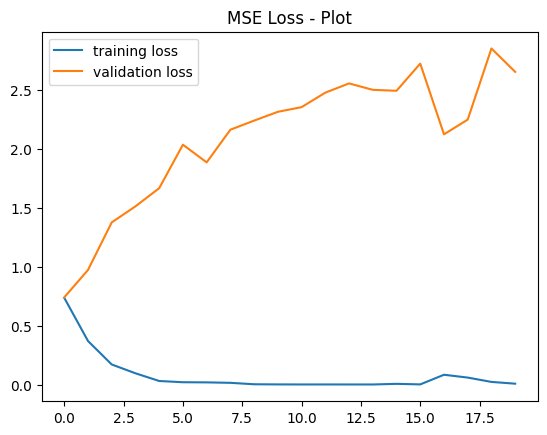

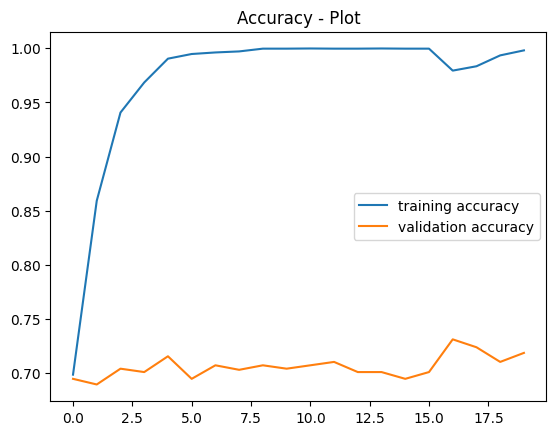

In [15]:
hyper_params = NLPHyperParams(dataset.processed_training_set[0])
training_dataloader = DataLoader(dataset.training(), batch_size=hyper_params.batch_size)
validation_dataloader = DataLoader(dataset.validation(), batch_size=hyper_params.batch_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("using device:", device)
model = MultiModalModel(hyper_params.params(), device)
optimizer = optim.AdamW(model.parameters(), lr=hyper_params.learning_rate, weight_decay=hyper_params.weight_decay)
criterion = nn.CrossEntropyLoss()
trainer = NLPTrainer(model, optimizer, criterion, device, hyper_params)
history = trainer.train(training_dataloader, validation_dataloader)
print(history)

print("### Summary")
print("average loss", history["avg_epoch_loss"])
print("average accuracy", history["avg_epoch_accuracy"])

plt.title("MSE Loss - Plot")
plt.plot(history["train_loss"], label="training loss")
plt.plot(history["valid_loss"], label="validation loss")
plt.legend()
plt.show()

plt.title("Accuracy - Plot")
plt.plot(history["train_accuracy"], label="training accuracy")
plt.plot(history["valid_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

In [ ]:
# uncomment to publish it
# model.save_pretrained("culturalitems-no-transformer")
# model.push_to_hub("fax4ever/culturalitems-no-transformer", token=userdata.get('HF_TOKEN'))